In [7]:
import torch
import torchvision
import torchvision.transforms as transforms # 
import torchvision.datasets.mnist as mnist  # to import data

# we use torch.cuda.Event(enable_timing=True) to measure time
# from timeit import default_timer as timer
# import time

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy                  # for copy.deepcopy( ... )

import matplotlib.pyplot as plt
import numpy as np

import collections
import torch.nn.init as init

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Assigment 1, part 2

## import data

In [43]:
transform1 = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform2 = transforms.Compose( [transforms.ToTensor(), transforms.Normalize( (0.1307,), (0.3081,)) ])
dl_path  = "./data_mnist"

trainset = mnist.MNIST( root = dl_path, train=True , download=True, transform = transform2 )
testset  = mnist.MNIST( root = dl_path, train=False, download=True, transform = transform2 )

training_dataset_size = len(trainset)
testing_dataset_size  = len(testset)

print( training_dataset_size )
print( testing_dataset_size )

60000
10000


##Exploration
display some samples

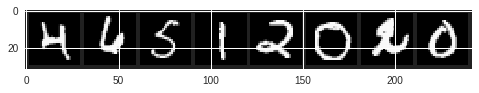

    4     6     5     1     2     0     2     0
img size =  torch.Size([8, 1, 28, 28]) label size =  torch.Size([8])


In [8]:
nb_sample = 8

trainloader = torch.utils.data.DataLoader(trainset, batch_size = nb_sample, shuffle=True , num_workers=2)
testloader  = torch.utils.data.DataLoader(testset , batch_size = nb_sample, shuffle=False, num_workers=2)

# functions to show an image

def imshow(img):
    img = ( img + 0.43 ) / 3.3    # to be in the interval [0,1]
    npimg = img.numpy()
    npimg = (255*npimg).astype(np.uint8) # to be a int in (0,...,255)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(nb_sample)))
print( "img size = " , images.size() , "label size = " , labels.size() )

## Define some modules

###MPL

In [0]:
class MLP(nn.Module):
    def __init__(self, h1, h2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, h1)
        self.fc2 = nn.Linear(h1 , h2)
        self.fc3 = nn.Linear(h2 , 10)

    def forward(self, x):
        x = x.view( -1, 28 * 28 )
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

###CNN
architecture taken from :
    https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [0]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self, kernel_sz = 3 ):
        
        if kernel_sz % 2 == 0 :
            raise ValueError("kernel size must be odd")
        pad = kernel_sz // 2 
        
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=( kernel_sz , kernel_sz ), padding=pad ),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=( kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(kernel_sz , kernel_sz), padding=pad),
            # nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(128, 10)

    def forward(self, x):
        return self.clf(self.conv(x).squeeze())

##Number of parameters
Print the number of parameters in each models and display the computation 

In [11]:
def number_of_params( net ) :
    nb_param  = 0
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    print( "number of params = " , nb_param , " = ", param_lst  )

mytestnet1 = MLP(h1=620,h2=620)
mytestnet2 = Classifier( kernel_sz=9 )
print("MLP:")
number_of_params( mytestnet1 )
print("CNN:")
number_of_params( mytestnet2 )
del mytestnet1
del mytestnet2

MLP:
number of params =  877930  =   
 (fc1.weight)             620*784
 (fc1.bias)             + 620
 (fc2.weight)           + 620*620
 (fc2.bias)             + 620
 (fc3.weight)           + 10*620
 (fc3.bias)             + 10
CNN:
number of params =  873738  =   
 (conv.0.weight)          16*1*9*9
 (conv.0.bias)          + 16
 (conv.3.weight)        + 32*16*9*9
 (conv.3.bias)          + 32
 (conv.6.weight)        + 64*32*9*9
 (conv.6.bias)          + 64
 (conv.9.weight)        + 128*64*9*9
 (conv.9.bias)          + 128
 (clf.weight)           + 10*128
 (clf.bias)             + 10


### Trying different initialization methods

In [12]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)
        
def zero_init ( layer ) :
    """Everything is set to zero"""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        layer.weight.data.fill_(0.0)
        layer.bias.data.fill_(0.0)
        
def norm_init ( layer ) :
    """Weiths are generated from std normal, biases are set to zero"""
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.normal_(layer.weight, mean=0, std=1)
        layer.bias.data.fill_(0.0)

cudanet = Classifier( kernel_sz = 9 )
# cudanet = MLP(h1=620,h2=620)

cudanet.apply( glorot_init )
# cudanet.apply( zero_init )
# cudanet.apply( norm_init )

# cudanet.load_state_dict(torch.load(path), strict=False)
cudanet.to(device)

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=128, out_features=10, bias=True)
)

##Training


In [0]:
def train_model(batchsize=16*64, lr=0.055):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cudanet.parameters(), lr=lr)
    nb_epoch  = 10
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,shuffle=True, num_workers=2)
    state_dict_list = list()

    for epoch in range( nb_epoch ):  # loop over the dataset multiple times

        # if epoch == 5 :
        #   optimizer = optim.SGD(cudanet.parameters(), lr=0.05, momentum=0.0, weight_decay=0) 

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cudanet(inputs)
            # if i == 0 : print( outputs )
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        else : # print every epoch
            print('epoch = %d, loss = %.8f' % (epoch + 1, running_loss / (i*8*64))) # nb of sample per mini-batch
            running_loss = 0.0
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in cudanet.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()

    else : 
        print('Finished Training')
    
    
def accuracy(cudanet, dataloader):
    correct = torch.tensor([0])
    total = torch.tensor([0])

    correct, total = correct.to(device) , total.to(device) 
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = cudanet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

    print('Accuracy of the network on the' , testing_dataset_size , ' images: %.2f %%' 
              % ( (100 * correct.double()) / total.double()  )
         )

In [0]:
!pip install sobol_seq

import sobol_seq

#log_batchsize_min = 0
log_batchsize_max = 10

lr_min = 0.01
lr_max = 0.5
        
if __name__ == '__main__':
  
    # random sobol hyperparameter search
    seq = sobol_seq.i4_sobol_generate(2, 10)
    for elem in seq:
        batchsize = 2 ** int( np.floor( elem[0] * ( log_batchsize_max + 1 ) ) )   #
        lr = float( (lr_max - lr_min) * elem[1] + lr_min )
        print("############### Search with batch size = {} and lr = {} ###############"
              .format(batchsize, lr))
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end   = torch.cuda.Event(enable_timing=True)
        start.record()
        train_model(batchsize, lr)
        end.record()
        torch.cuda.synchronize()
        print( "time required = " , start.elapsed_time(end)*0.001 , " s ")
        
        #test accuracy
        print("Test accuracy: ")
        testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,shuffle=True, num_workers=2)
        accuracy(cudanet, testloader)
        
        #training accuracy
        print("Training accuracy: ")
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,shuffle=True, num_workers=2)
        accuracy(cudanet, trainloader)
        
        ###Until here

############### Search with batch size = 32 and lr = 0.255 ###############
epoch = 1, loss = 0.00450043
epoch = 2, loss = 0.00450094
epoch = 3, loss = 0.00450037
epoch = 4, loss = 0.00450065
epoch = 5, loss = 0.00450039
epoch = 6, loss = 0.00450045
epoch = 7, loss = 0.00450045
epoch = 8, loss = 0.00450060
epoch = 9, loss = 0.00450081
epoch = 10, loss = 0.00450054
Finished Training
time required =  201.66246875000002  s 
Test accuracy: 
Accuracy of the network on the 10000  images: 11.35 %
Training accuracy: 
Accuracy of the network on the 10000  images: 11.24 %
############### Search with batch size = 256 and lr = 0.1325 ###############
epoch = 1, loss = 0.00451500
epoch = 2, loss = 0.00451401
epoch = 3, loss = 0.00451399
epoch = 4, loss = 0.00451395
epoch = 5, loss = 0.00451405
epoch = 6, loss = 0.00451396
epoch = 7, loss = 0.00451399
epoch = 8, loss = 0.00451402
epoch = 9, loss = 0.00451399
epoch = 10, loss = 0.00451401
Finished Training
time required =  130.1457109375  s 
Test accur

compare accuracy across epoch on training-test dataset

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 8*64, shuffle=True , num_workers=2)
testloader  = torch.utils.data.DataLoader(testset , batch_size = 8*64, shuffle=True , num_workers=2)

accuracy = torch.ones(nb_epoch,2, dtype=torch.float) * 100
for epoch , tmp_state_dict in enumerate(state_dict_list,0) :
    if epoch % 1 != 0 :
        continue
    
    # net_model = cudanet.__class__
    # cudaTOCPUnet = net_model(h1,h2)
    # cudaTOCPUnet = Classifier( kernel_sz = 9 )
    cudaTOCPUnet = copy.deepcopy( cudanet )
    cudaTOCPUnet.load_state_dict( tmp_state_dict )
    cuda_test_net = copy.deepcopy(cudaTOCPUnet).to(device)
    
    correct = torch.tensor([0,0])
    total   = torch.tensor([0,0])
    
    correct, total = correct.to(device) , total.to(device) 
        
    loader_list = [ testloader , trainloader ]
    with torch.no_grad():
        for i, loader in enumerate(loader_list,0) :
            for data in loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = cuda_test_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total[i] += labels.size(0)
                correct[i] += (predicted == labels).sum()
    
    accuracy[epoch,:] = accuracy[epoch,:] * correct.type(torch.FloatTensor) / total.type(torch.FloatTensor)
    
    print('epoch %3d : Accuracy of the network on the test images: %.2f %% , training images %.2f %% ' 
              % ( epoch+1, accuracy[epoch,0] , accuracy[epoch,1] )
         )

Plot the train and validation errors for each of the model

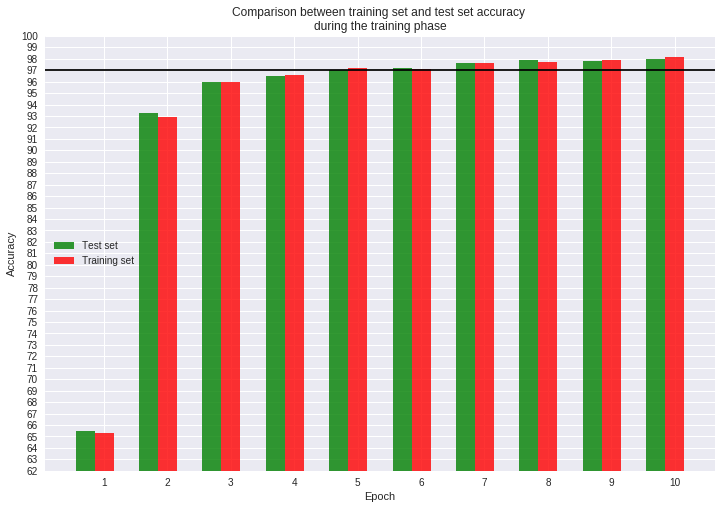

In [25]:
from matplotlib.pyplot import figure
# import warnings
# warnings.filterwarnings('ignore')

# data to plot
n_groups = nb_epoch
accuracy_toplot = accuracy.numpy()

tests_accuracy = accuracy_toplot[:,0]
train_accuracy = accuracy_toplot[:,1]

#
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12 ,8)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8
 
rects1 = plt.bar(index, tests_accuracy, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test set')
 
rects2 = plt.bar(index + bar_width, train_accuracy, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Training set')

eps = 3 
top = min(int( np.ceil(accuracy_toplot.max() + eps)) , 100)
bot = max(int(np.floor(accuracy_toplot.min() - eps)) , 0  )


plt.ylim(bot, top)     # set the ylim to bottom, top
plt.axhline(y=97,color="black")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparison between training set and test set accuracy \nduring the training phase')
plt.xticks(index + bar_width, range(1,11,1) )
plt.yticks( range(bot,top+1,1) )
plt.legend()

# plt.tight_layout()
plt.show()

## Some additionnal stuff

##### 3-best accuracy : having the right label in the net's top 3 answers count as a good answer

In [26]:
correct = torch.tensor([0])
total = torch.tensor([0])

correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = cudanet(images)
        predicted = torch.topk(outputs.data, 3)[1]
        total += labels.size(0)
        correct += (predicted[:,0] == labels).sum()
        correct += (predicted[:,1] == labels).sum()
        correct += (predicted[:,2] == labels).sum()

print('3-best Accuracy of the network on the ' , testing_dataset_size , ' test images: %.3f %%' 
          % ( 100 * correct.double() / total.double())
     )

3-best Accuracy of the network on the  10000  test images: 99.910 %


#### print some test sample that the net misclassifies

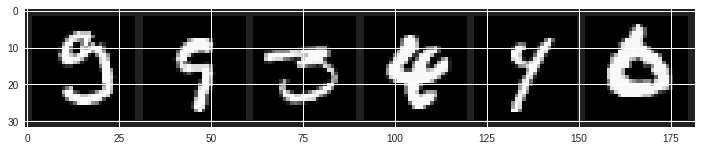

this should be :   9, 9, 3, 4, 4, 6
net choice # 1 :   5, 5, 5, 8, 9, 0
net choice # 2 :   9, 9, 3, 4, 4, 6
net choice # 3 :   0, 7, 7, 6, 7, 5


In [27]:
nb_of_error = torch.tensor([6])
j = torch.tensor([0])
errorimages  = torch.empty(6,1,28,28)
errorlabels  = torch.empty(6)
erroroutputs = torch.empty(6, 10)
for images, labels in testloader :
    images, labels = images.to(device), labels.to(device)
    outputs = cudanet(images)
    _, predicted = torch.max(outputs.data, 1)
    if not (predicted == labels).sum() == labels.size()[0] :
        comparison = (predicted == labels)
        for i,b in enumerate( comparison ) :
            if b == 0 :
                errorimages[j,:,:,:] = copy.deepcopy(images[i,:,:,:]).cpu()
                errorlabels[j] = labels[i].clone().detach().requires_grad_(False).cpu()
                erroroutputs[j,:] = outputs[i,:].clone().detach().requires_grad_(False).cpu()
                j = j + 1
                if j.item() >= nb_of_error.item() :
                    break
        else :
            continue
        break
        
if j.item() == 0 :
    print( "no error found")
else :
    imshow( torchvision.utils.make_grid(errorimages) )
    
    print( "this should be : " , ",".join( "%2d" % nb.item() for nb in errorlabels ) ) 
    for i in range(3) :
        print( "net choice #" , i+1 , ": " , ",".join( "%2d" % nb.item() for nb in list(torch.topk( erroroutputs, 3)[1][:,i]) ) ) 

### Save and load models

#### Save the state_dict of the model for each epoch on a local directory

In [28]:
local_path = "./save"
for epoch , tmp_state_dict in enumerate(state_dict_list,1) :
    saving_path = local_path + "/dev1num2model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    torch.save( tmp_state_dict , saving_path)

FileNotFoundError: ignored

#### load from file and set the load the state_dict of the last epoch on a object
the files have to be located in "./save" and named "dev1num2model_for_epoch{j}.pth" for j from ... to ...

In [0]:
local_path = "./save"
state_dict_list = list()

from_idx = 1
to_idx = 10

for epoch in range( from_idx  , to_idx + 1 , 1 ):
    path = local_path + "/dev1num2model_for_epoch{Epoch}.pth".format( Epoch = epoch )
    tmp_dict = torch.load(path)
    state_dict_list.append(tmp_dict)
    print( path )
else : 
    cudanet = Classifier( kernel_sz = 9 )
    cudanet.load_state_dict(tmp_dict)
    cudanet.eval()                     